In [1]:
from operator import itemgetter
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
import numpy as np
import matplotlib.pyplot as plt


class Group:
    def __init__(self, group_classes):
        self.group_classes = group_classes
        self.entropy = self.group_entropy()

    def __len__(self):
        return len(self.group_classes)

    def group_entropy(self):
        values = np.unique(self.group_classes, return_counts=True)[1]
        return sum([(-value/len(self) * math.log(value/len(self))) for value in values])


class Node:
    def __init__(self):
        self.split_feature = 0
        self.split_val = 0
        self.child_node_a = None
        self.child_node_b = None
        self.val = None

    def predict(self, data):
        if self.val is not None:
            return self.val
        if data[self.split_feature] < self.split_val:
            return self.child_node_a.predict(data)
        return self.child_node_b.predict(data)


class DecisionTreeClassifier(object):
    def __init__(self, max_depth, dec_precision):
        self.max_depth = max_depth
        self.dec_precision = dec_precision
        self.tree = None

    @staticmethod
    def get_split_entropy(group_a, group_b):
        return (group_a.entropy * len(group_a) + group_b.entropy * len(group_b)) \
               / (len(group_a) + len(group_b))

    @staticmethod
    def get_information_gain(classes, splitter):
        parent_group = Group(classes)
        child_group_a = Group(classes[:splitter])
        child_group_b = Group(classes[splitter:])
        return parent_group.entropy - DecisionTreeClassifier.get_split_entropy(child_group_a, child_group_b)

    @staticmethod
    def has_same_values(data):
        return np.unique(data).size == 1

    @staticmethod
    def get_dominating_class(classes):
        assert len(classes) != 0, "Class list is empty"
        values, counts = np.unique(classes, return_counts=True)
        return max(zip(values, counts), key=itemgetter(1))[0]

    def get_best_feature_split(self, feature_values, original_classes):
        assert len(feature_values) > 1 and not self.has_same_values(feature_values), "Splitter has nothing to split on"
        joined = sorted(zip(feature_values, original_classes), key=itemgetter(0))
        values = [value[0] for value in joined]
        classes = [value[1] for value in joined]
        increment = 10 ** self.dec_precision
        current_split = round(joined[0][0], -self.dec_precision) + (0.5 * increment)
        best_split, best_gain = None, None
        i = 1

        while i < len(joined):
            if values[i-1] <= current_split < values[i]:
                gain = self.get_information_gain(classes, i)
                if best_gain is None or gain > best_gain:
                    best_gain = gain
                    best_split = (values[i-1] + values[i])/2
                while current_split < values[i]:
                    current_split += increment
            i += 1

        return best_split, best_gain

    def get_best_split(self, data, classes, used_features):
        assert len(data) > 1, "Data set too small for splitting"
        best_feature, best_split, best_gain = None, None, None
        features = [i for i in range(len(data[0]))
                    if i not in used_features
                    and not self.has_same_values(np.array([round(data_tuple[i], -self.dec_precision)
                                                           for data_tuple in data]))]

        for feature in features:
            split, gain = self.get_best_feature_split(np.array([data_tuple[feature] for data_tuple in data]), classes)
            if best_gain is None or (gain is not None and gain > best_gain):
                best_feature = feature
                best_gain = gain
                best_split = split

        return best_feature, best_split  # None, None = every data tuple was the same or no available features

    def build_tree(self, data, classes, current_node=None, used_features=None, depth=0):
        assert len(data) == len(classes), "List sizes don't match"
        if current_node is None:
            self.tree = Node()
            current_node = self.tree
            used_features = set()
        if len(data) == 1 or self.has_same_values(classes) or depth == self.max_depth:
            current_node.val = self.get_dominating_class(classes)
            return

        feature, split = self.get_best_split(data, classes, used_features)
        if feature is None or split is None:
            current_node.val = self.get_dominating_class(classes)
            return
        new_used_features = used_features.copy()
        new_used_features.add(feature)
        current_node.split_feature = feature
        current_node.split_val = split
        current_node.child_node_a = Node()
        current_node.child_node_b = Node()

        new_data, new_classes = [[], []], [[], []]
        for i in range(len(data)):
            category = 0 if data[i][feature] < split else 1
            new_data[category].append(data[i])
            new_classes[category].append(classes[i])

        self.build_tree(np.array(new_data[0]), np.array(new_classes[0]),
                        current_node.child_node_a, new_used_features, depth + 1)
        self.build_tree(np.array(new_data[1]), np.array(new_classes[1]),
                        current_node.child_node_b, new_used_features, depth + 1)

    def predict(self, data):
        return self.tree.predict(data)

Kod do klasy tworzącej drzewo decyzyjne. Umożliwia ustawienie głębokości (po maksymalnie ilu cechach należy dokonać podziału) i precyzji ("ziarnistość" podziału - czy sprawdzać entropię co 1, 0.1, 0.01, ... w danych).

In [2]:
def test_tree(dataset, ts, depth, dec_precision=-1, rs=None, print_mode=2):
    x_train, x_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=ts, random_state=rs)
    dc = DecisionTreeClassifier(depth, dec_precision)
    dc.build_tree(x_train, y_train)
    correct_guesses = 0
    for sample, gt in zip(x_test, y_test):
        prediction = dc.predict(sample)
        if print_mode == 0:
            print("Predicted:", prediction, "actual:", gt)
        if prediction == gt:
            correct_guesses += 1

    if print_mode == 0:
        print("\nAccuracy:", correct_guesses/len(y_test), "\n\n\n")
    elif print_mode == 1:
        print("Accuracy:", correct_guesses / len(y_test))
    return correct_guesses/len(y_test)

Funkcja, która umożliwia sprawdzenie działania drzewa - wypisanie przewidywanych i faktycznych wartości oraz celności drzewa. Przykładowe wywołanie:

In [3]:
iris = load_iris()
test_tree(iris, 0.1, 3, -1, 123, 0)

Predicted: 1 actual: 1
Predicted: 2 actual: 2
Predicted: 2 actual: 2
Predicted: 1 actual: 1
Predicted: 0 actual: 0
Predicted: 2 actual: 2
Predicted: 1 actual: 1
Predicted: 0 actual: 0
Predicted: 0 actual: 0
Predicted: 1 actual: 1
Predicted: 2 actual: 2
Predicted: 0 actual: 0
Predicted: 1 actual: 1
Predicted: 2 actual: 2
Predicted: 2 actual: 2

Accuracy: 1.0 





1.0

W tym przypadku drzewo poprawnie zakwalifikowało każdą próbkę.

Dokładniejsze jest wielokrotne tworzenie i testowanie drzewa, a potem liczenie średniej z celności:

In [4]:
accuracy = 0
for _ in range(10):
    accuracy += test_tree(iris, 0.1, 3, -1, print_mode=1)
print("\nAverage accuracy:", accuracy/10, "\n\n\n")

Accuracy: 1.0
Accuracy: 0.8666666666666667
Accuracy: 0.9333333333333333
Accuracy: 0.8
Accuracy: 1.0
Accuracy: 0.9333333333333333
Accuracy: 1.0
Accuracy: 0.9333333333333333
Accuracy: 0.9333333333333333
Accuracy: 0.9333333333333333

Average accuracy: 0.9333333333333333 





In [5]:
def mass_test(dataset, max_depth, dec_precision, test_count):
    sizes = [size / 10 for size in range(1, 10)]
    depths = [depth for depth in range(max_depth+1)]
    results = [[] for _ in range(max_depth+1)]
    for size in sizes:
        for depth in depths:
            accuracy = 0
            for _ in range(test_count):
                accuracy += test_tree(dataset, size, depth, dec_precision=dec_precision, print_mode=2)
            results[depth].append(accuracy / test_count)

    fig, ax = plt.subplots()
    x_axis = sizes
    for i in range(max_depth+1):
        ax.plot(x_axis, results[i], label=f'Depth {i}')
    ax.legend()
    plt.title(f"Accuracies for various depths and test sizes: precision {dec_precision}")
    plt.show()

Funkcja, która wygeneruje wykres celności od głębokości drzewa i stosunku próbki trenującej do testowej. Przykładowe wywołanie:

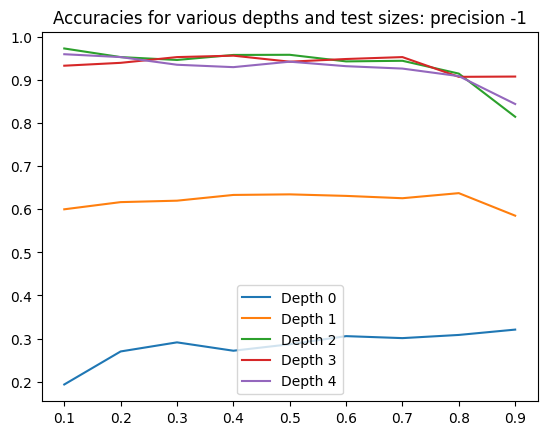

In [6]:
mass_test(iris, 4, -1, 10)

Dla tych danych osiągnięcie sensownych wyników wymaga głębokości 2. Można też zauważyć, że zbyt mała próbka trenująca pogarsza jakość drzewa.

Dla głębokości 0 (szukającej tylko najczęstszej klasy) zależność jest odwrotna - przy równych proporcjach w oryginalnym zbiorze dominująca klasa w zbiorze trenującym jest najmniej liczną w testowym, ale przy coraz większym zbiorze testowym celność dąży do tej, którą dałoby losowe wybieranie (0.33).

W implementacji algorytmu dodałem jeszcze parametr granularności podziału próbek. Celność dla mniej precyzyjnych wartości:

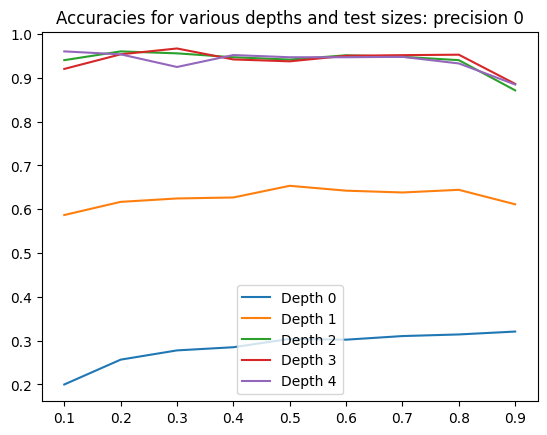

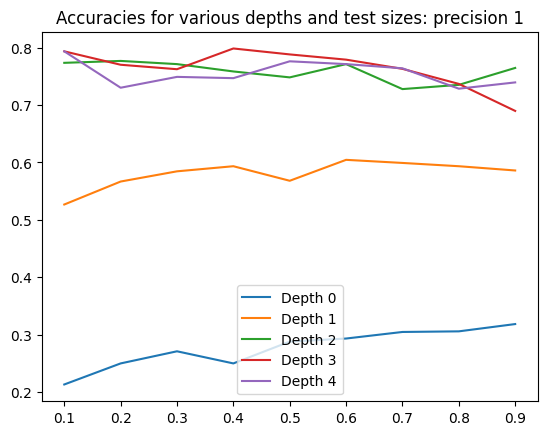

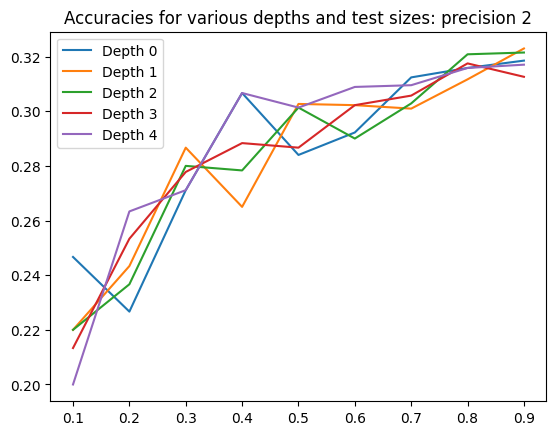

In [7]:
mass_test(iris, 4, 0, 10)
mass_test(iris, 4, 1, 10)
mass_test(iris, 4, 2, 10)

Wraz ze zmniejszaniem precyzji drzewo daje coraz gorze wyniki. Przy precyzji 2 (zaokrąglanie do 10^2) każda próbka jest widziana jako taka sama, przez co wyniki są takie, jak dla drzewa o głębokości 0.